In [1]:
import sys
import numpy as np
import math
import pandas as pd
import random

from scipy import stats

%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=16)
matplotlib.rcParams['axes.labelweight'] = 'bold'

In [2]:
week = 'Week2'
day  = 'Wed'

In [165]:
# Get the ratings by user ID: starts at user index 1 
r = pd.read_csv('goodbooks-10k/ratings.csv')
df_ratings = pd.DataFrame(r)

# Add counts to the df
cut = 175
df_ratings['user_counts'] = df_ratings.groupby(['user_id'])['book_id'].transform('count')
df_ratings['book_counts'] = df_ratings.groupby(['book_id'])['user_id'].transform('count')

df_ratings_cut = df_ratings.query('user_counts > %d'%cut)
# Add an index for the user for matrix making later
df_ratings_cut['user_idx'] = pd.Categorical(df_ratings_cut['user_id']).codes - 1
df_ratings_cut['book_idx'] = pd.Categorical(df_ratings_cut['book_id']).codes - 1

# ...but also do a groupby, so can plot easily
df_ratings_count_u = df_ratings.groupby(['user_id']).size().reset_index(name='Counts')
df_ratings_count_u_cut = df_ratings_count_u.query('Counts > %d'%cut)

df_ratings_book_count_u = df_ratings.groupby(['book_id']).size().reset_index(name='Counts')
#df_ratings_book_count_u_cut = df_ratings_book_count_u.query('Counts > %d'%cut)

df_ratings_count_u_cut = df_ratings_count_u.query('Counts > %d'%cut)


# Get the ratings by book 
r = pd.read_csv('goodbooks-10k/books.csv')
df_books = pd.DataFrame(r)
df_books.head()
df_books_cut = df_books.query('ratings_count < 30000')

# Set number of books and users variables for later use
N_BOOKS = df_books.shape[0]
N_USERS = len(df_ratings_count_u_cut.user_id.unique())
N_USERS_TEST = 1000
N_FEATURES = 40
LEAVE_OUT_PERC = 0.2

print(N_BOOKS,N_USERS)# ,df_ratings_count_u_cut.shape[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


10000 537


In [167]:
#df_ratings.head()
#df_ratings_cut.head()
print(df_ratings.shape,df_ratings_cut.shape, df_ratings_count_u_cut.shape)
print(df_ratings_cut.head())
print(df_ratings_count_u)

(5976479, 5) (98172, 7) (537, 2)
      user_id  book_id  rating  user_counts  book_counts  user_idx  book_idx
2921      173       14       4          176        14328         0        12
2922      173      782       4          176         1886         0       780
2923      173      531       3          176         2643         0       529
2924      173      763       4          176         1700         0       761
2925      173      646       3          176         2723         0       644
       user_id  Counts
0            1     117
1            2      65
2            3      91
3            4     134
4            5     100
5            6      90
6            7     155
7            8      98
8            9     132
9           10     128
10          11     120
11          12     113
12          13      96
13          14     108
14          15      97
15          16      68
16          17      61
17          18     109
18          19     119
19          20      90
20          21      61

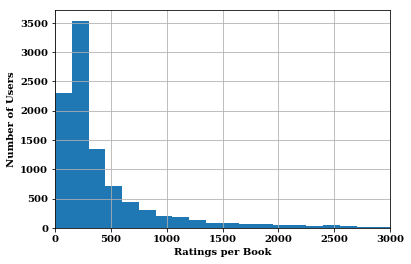

In [56]:
plt.figure(figsize=(6,4))
plt.hist(df_ratings_book_count_u['Counts'].values,bins=20,range=(0,3000))
plt.xlim(0,3000)
#plt.ylim(0,12500)
plt.grid(True)
#plt.axvline(cut,label='Cut = %d'%cut,color='r',lw=3,ls='--')
plt.xlabel('Ratings per Book')
plt.ylabel('Number of Users')
plt.savefig('Plots/%s_%s_ratings_per_book_w_cut.png'%(week,day))

## Get Ratings/User and Ratings/Book

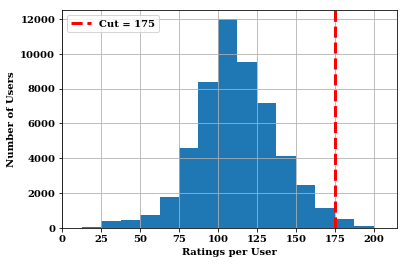

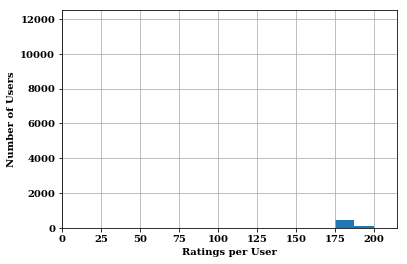

In [7]:
# Ratings
plt.figure(figsize=(6,4))
plt.hist(df_ratings_count_u['Counts'].values,bins=20,range=(0,250))
plt.xlim(0,215)
plt.ylim(0,12500)
plt.grid(True)
plt.axvline(cut,label='Cut = %d'%cut,color='r',lw=3,ls='--')
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.legend()
plt.savefig('Plots/%s_%s_ratings_per_user.png'%(week,day))

# Ratings with cut on number of user responses
plt.figure(figsize=(6,4))
plt.hist(df_ratings_count_u_cut['Counts'].values,bins=20,range=(0,250))
plt.xlim(0,215)
plt.ylim(0,12500)
plt.grid(True)
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.savefig('Plots/%s_%s_ratings_per_user_cut.png'%(week,day))

# Ratings with cut on number of user responses
# plt.figure(figsize=(6,4))
# _,_,_ = plt.hist(df_books.ratings_count.values,range=(0,300000),bins=20)
# plt.grid(True)
# plt.xlabel('Ratings per Book')
# plt.ylabel('Number of Book')
# plt.xlim(0,300000)
# plt.savefig('Plots/%s_%s_ratings_per_book.png'%(week,day))

## Build a Rant Matrix

In [13]:
from validation_figs import *

In [144]:
# First, define a matrix size num_books x num_users
ratings_mat = np.zeros((N_USERS,N_BOOKS))
binary_mat = np.zeros((N_USERS,N_BOOKS))
Y, R = ratings_mat, binary_mat

# Now fill the rank matrix and validation matrix
for i in range(df_ratings_cut.shape[0]):
    user_i = df_ratings_cut.user_idx.values[i]
    book_i = df_ratings_cut.book_id.values[i]
    rating_i = df_ratings_cut.rating.values[i]
    
    ratings_mat[user_i][book_i - 1] = rating_i
    binary_mat[user_i][book_i - 1] = 1

In [145]:
print(ratings_mat.shape)

(537, 10000)


In [146]:
# "Visualize the ratings matrix"
# fig = plt.figure(figsize=(6,20)) # 10*(10000./537)))
# plt.imshow(ratings_mat.T)
# #plt.colorbar()
# plt.xlabel('Books (%d)'%N_BOOKS,fontsize=18)
# plt.ylabel('Users (%d)'%N_USERS,fontsize=18)
# plt.ylim(0,2500)
# plt.xticks([])
# plt.yticks([])
# plt.savefig('Plots/%s_%s_matrix_size.png')

In [147]:
sparsity = float(len(ratings_mat.nonzero()[0]))
sparsity /= (ratings_mat.shape[0] * ratings_mat.shape[1])
sparsity *= 100
print( 'Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.83%


In [148]:
from algorithms import CosSimilarityRecommender

# init, fit to training data, predict
user_rec = CosSimilarityRecommender(kind='user')
user_rec.fit(train_set)
user_similarity = rec.predict(train_set) # predictions

item_rec = CosSimilarityRecommender(kind='item')
item_rec.fit(train_set)
item_similarity = rec.predict(train_set) 

In [149]:
print(train_set.shape,user_similarity.shape)

(10000, 537) (10000, 537)


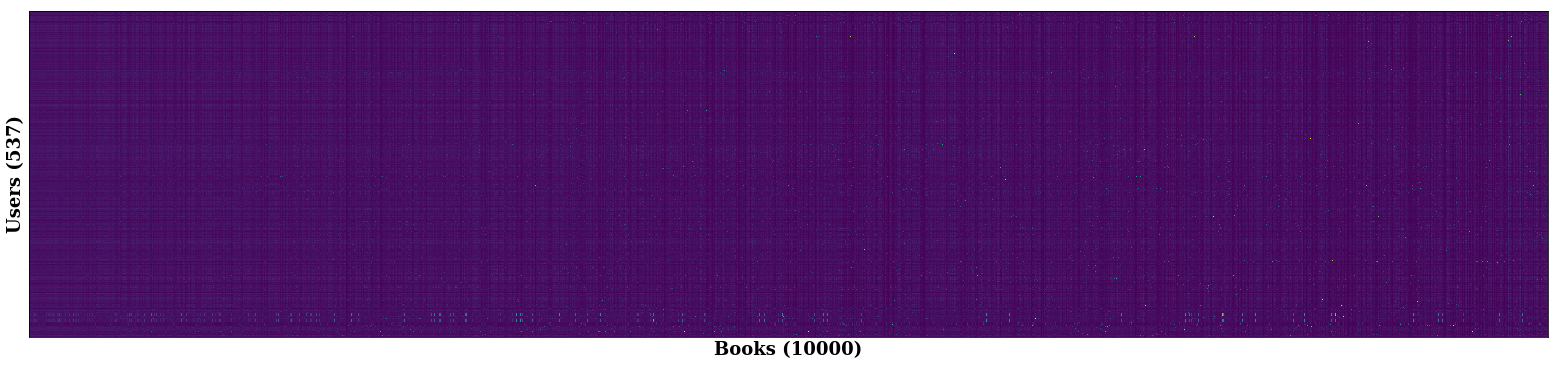

In [68]:
# "Visualize the ratings matrix"
fig = plt.figure(figsize=(40,6)) # 10*(10000./537)))
plt.imshow(user_similarity.T)
#plt.colorbar()
plt.xlabel('Books (%d)'%N_BOOKS,fontsize=18)
plt.ylabel('Users (%d)'%N_USERS,fontsize=18)
plt.xlim(0,2500)
plt.xticks([])
plt.yticks([])
plt.savefig('Plots/%s_%s_matrix_size.png')

In [77]:
def predict_fast_simple(ratings, similarity, kind='user'):
    print(ratings.shape,similarity.shape)
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [98]:
user_prediction = predict_fast_simple(train_set.T, user_similarity, kind='user')
item_prediction = predict_fast_simple(train_set.T, item_similarity, kind='user')
#print(user_predictions)

(537, 10000) (10000, 537)
(537, 10000) (10000, 537)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [99]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [101]:
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test_set)))
#print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test_set)))

User-based CF MSE: 12.220951909437177


In [115]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        print(ratings.shape[0])
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            #print(top_k_users)

            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [121]:
pred = predict_topk(train_set.T, user_similarity.T, kind='user', k=10)

537


In [122]:
print( 'Top-k User-based CF MSE: ' + str(get_mse(pred.T, test_set)))

Top-k User-based CF MSE: 12.686089513345143


In [136]:
#pred = predict_topk(train_set.T, item_similarity.T, kind='item', k=40)
#print( 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

In [126]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train_set.T, user_similarity.T, kind='user', k=k)
    #item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred.T, train_set)]
    user_test_mse += [get_mse(user_pred.T, test_set)]
    
    #item_train_mse += [get_mse(item_pred, train)]
    #item_test_mse += [get_mse(item_pred, test)]  


537
537
537
537
537
537


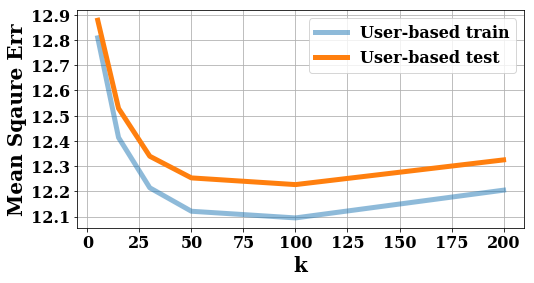

In [133]:
plt.figure(figsize=(8, 4))
plt.plot(k_array, user_train_mse, label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, label='User-based test', linewidth=5)
#plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
#plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=20);
plt.ylabel('Mean Sqaure Err', fontsize=20)
plt.grid(True)

plt.savefig('Plots/%s_%s_MSE_v_k.png'%(week,day))


In [203]:
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr

from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score

In [206]:
# # df_ratings_user_aves_u = df_ratings.groupby(\
# #                     ['user_id', 'rating']).mean()  

# # dr_ratings_user_aves_u = df_ratings.groupby('user_id').agg({'rating': 'mean'})
# #df_test = df_ratings.groupby(['user_id'])['rating'].sum()
# df_test.groupby(['user_id']).sum().reset_index().groupby('rating').mean()
# df_test.groupby(['rating']).describe()
#df_test.head()

In [141]:
print(min(user_similarity[0]),max(user_similarity[0]))
print(user_similarity.shape)

0.9535009116439668 2.2222717899943123
(10000, 537)


In [219]:
nonzero_test = test_set > 0

# get non-zero test entries, since we can't evaluate for unsubmitted ratings!
y_true = test_set[nonzero_test]
y_pred = user_similarity[nonzero_test]

# Continous version of predictions, scaled to 0, 1
y_pred_scaled = (y_pred - 1.) / 4.

# binarize true values and predictions
y_pred_binarized = binarize(y_pred.copy(), 5)
y_true_binarized = binarize(y_true.copy(), 5)

In [220]:
#plt.hist(y_true)

Recall: 0.000
Precision: 0.000
F1 score: 0.000
ROC-AUC: 0.545


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


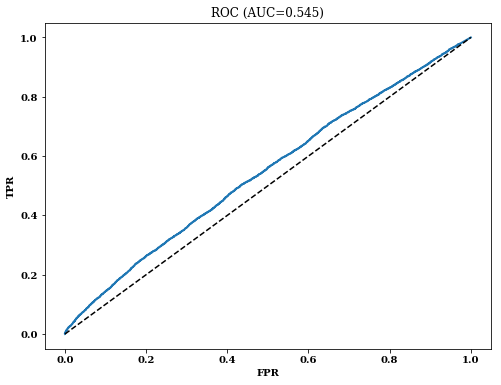

In [222]:
# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print( 'Recall: %0.3f' % recall_score(y_true_binarized, y_pred_binarized))
print( 'Precision: %0.3f' % precision_score(y_true_binarized, y_pred_binarized))
print( 'F1 score: %0.3f' % f1_score(y_true_binarized, y_pred_binarized))

# roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true_binarized, y_pred_scaled)
print( 'ROC-AUC: %0.3f' % auc_score)

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binarized, y_pred_scaled)
pl.figure(figsize=(8, 6))
pl.plot(fpr, tpr, lw=2)
pl.plot([0, 1], [0, 1], 'k--')
pl.title('ROC (AUC=%0.3f)' % auc_score)
pl.xlabel('FPR')
pl.ylabel('TPR')
plt
pl.show()

In [21]:
def cost(x_theta, y, R, u, lam = 0.):
    
    x = x_theta[:N_BOOKS*N_FEATURES].reshape((N_BOOKS,N_FEATURES))
    theta = x_theta[N_BOOKS*N_FEATURES:].reshape((N_USERS,N_FEATURES))
    
    h = np.dot(x,theta.T)
    # Only take into account rated movies (mult with R)
    h_R = np.multiply(h,R) - y

    # Include regularization
    cost = 0.5 * np.sum( pow(h_R,2) )\
        + (lam/2.) *( np.sum(np.square(theta)) + np.sum(np.square(x))) 
   
    print('Cost',cost)
    return float(cost) 

def grad(x_theta, y, R, u, lam=0.):
    
    x = x_theta[:N_BOOKS*N_FEATURES].reshape((N_BOOKS,N_FEATURES))
    theta = x_theta[N_BOOKS*N_FEATURES:].reshape((u,N_FEATURES))
      
    #print('and here are x and theta ', x.shape,theta.shape)
    h = np.dot(x,theta.T)    
    #print('and here are h and R and Y ', h.shape,R.shape,y.shape)
    h_R = np.multiply(h,R) - y
    
    x_grad = h_R.dot(theta) + lam * x
    theta_grad = h_R.T.dot(x) + lam * theta
    
    X_flat = x_grad.reshape([-1,1])
    Theta_flat = theta_grad.reshape([-1,1])
    X_Theta_flat = np.concatenate((X_flat,Theta_flat))
  
    return X_Theta_flat.reshape(len(X_Theta_flat),)
    
# Function that reshapes X and Theta
def reshape(flat, nbooks, nusers, nfeatures):
    assert flat.shape[0] == int(N_BOOKS*N_FEATURES + N_USERS*N_FEATURES)
    
    x = flat[:int(nbooks*nfeatures)].reshape((nbooks,nfeatures))
    theta = flat[int(nbooks*nfeatures):].reshape((nusers,nfeatures))
    
    return x, theta

In [22]:
#from ahack_functions import cost, grad, reshape

In [30]:
orig_ratings = np.zeros((N_BOOKS,1))
orig_ratings[473]  = 5
orig_ratings[1325] = 5
orig_ratings[1911] = 5
orig_ratings[2207] = 5
orig_ratings[2888]  = 5
orig_ratings[7240]  = 5
orig_ratings[551]  = 5
orig_ratings[61]  = 5
orig_ratings[1433] = 5
orig_ratings[1508] = 5
orig_ratings[200] = 5

Y, R = ratings_mat, binary_mat
Y_new = np.hstack((Y,orig_ratings))
R_new = np.hstack((R,orig_ratings > 0))
N_BOOKS, N_USERS = Y_new.shape

In [32]:
# X is N_BOOKS × N_FEATURES (40) matrix 
# Theta is N_USERS × N_FEATURES (40) matrix
X_mat = np.random.rand(N_BOOKS,N_FEATURES)
Theta_mat = np.random.rand(N_USERS,N_FEATURES)

X_Theta_rand = np.concatenate((X_mat.reshape([-1,1]),Theta_mat.reshape([-1,1])))

In [33]:
from scipy.optimize import fmin_cg

result = fmin_cg(cost, x0=X_Theta_rand,fprime=grad, \
                 args=(Y_new,R_new,N_USERS,1.),\
                 maxiter=2,disp=True) 

Cost 116539964.85077213
Cost 113866948.88470756
Cost 104041515.36300793
Cost 78450795.84875926
Cost 61495091.70346355
Cost 54071175.99824718
         Current function value: 54071175.998247
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6


In [13]:
# Reshape the trained output into sensible "X" and "Theta" matrices
rX, rTheta = reshape(result, N_BOOKS, N_USERS, N_FEATURES)
print (rX.shape,rTheta.shape)

(10000, 40) (51425, 40)


In [152]:
# The mean is only counting movies that were rated
#Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
#Ymean = Ymean.reshape((Ymean.shape[0],1))
#print(np.sum(R,axis=1))

In [14]:
prediction_matrix = rX.dot(rTheta.T)
#predictions = prediction_matrix[:,-1] + Ymean.flatten()
predictions = prediction_matrix[:,-1]

In [31]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(predictions)
pred_idxs_sorted = pred_idxs_sorted[::-1]

print(pred_idxs_sorted)

print( "Top recommendations for you:")
for i in range(6):
    new_book = df_books.query('book_id == %d'%pred_idxs_sorted[i])
    print('Predicting rating %0.1f for book "%s"' % \
    (predictions[pred_idxs_sorted[i]],new_book['title'].values[0]))
    
print ("\nOriginal ratings provided:")
for i in range(len(orig_ratings)):
    if orig_ratings[i] > 0:
        #print ('here we are ', i)
        new_book_2 = df_books.query('book_id == %d' % i)
        print ('Rated %d for "%s"' % (orig_ratings[i],new_book_2['title'].values[0]))

[8557 7465 3225 ...    4    7   25]
Top recommendations for you:
Predicting rating 10.1 for book "Tales From the Hood (The Sisters Grimm, #6)"
Predicting rating 9.9 for book "The Haunted Mask (Goosebumps, #11)"
Predicting rating 9.9 for book "Wings of Fire: An Autobiography"
Predicting rating 9.8 for book "CivilWarLand in Bad Decline"
Predicting rating 9.7 for book "The Unidentified Redhead (Redhead, #1)"
Predicting rating 9.7 for book "Stolen Innocence: My Story of Growing Up in a Polygamous Sect, Becoming a Teenage Bride, and Breaking Free of Warren Jeffs"

Original ratings provided:
Rated 5 for "The Girl on the Train"
Rated 5 for "And Then There Were None"
Rated 5 for "In the Woods (Dublin Murder Squad, #1)"
Rated 5 for "Life After Life"
Rated 5 for "The Likeness (Dublin Murder Squad, #2)"
Rated 5 for "The Woman in Cabin 10"
Rated 5 for "In a Dark, Dark Wood"
Rated 5 for "Faithful Place (Dublin Murder Squad, #3)"
Rated 5 for "Broken Harbour (Dublin Murder Squad, #4)"
Rated 5 for "Th

In [152]:
import requests
CLIENT_ID = 'qc6JdYnnj3G1fpQSsp4n1w'
CLIENT_SECRET = 'zD8IroPsQVDvco4V2u9h6hMgV1F3lsIO6FxKiq9eU'

In [ ]:
multi_r = requests.get('https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET')
